In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv(
    r'C:\Users\KIRAN\OneDrive\Desktop\CSV Files\all-data.csv',
    encoding="latin-1",
    header=None,
    names=["sentiment", "sentence"]
)

In [13]:
df.head()

,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [14]:
df.sentiment.value_counts()

sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

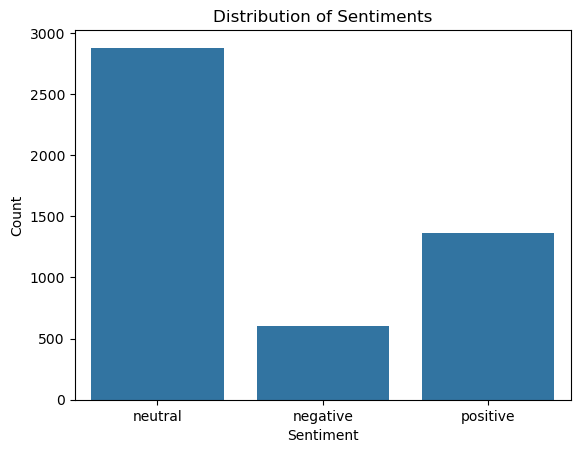

In [15]:
# plotting the distribution of sentiments
sns.countplot(x=df.sentiment)
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [18]:
texts = df["sentence"].astype(str).fillna("")

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=1000,   # 500–1000 is a good “reasonable size”
    min_df=2
)

X = tfidf.fit_transform(texts)  # sparse matrix

In [20]:
# Important: some rows may become all-zero after preprocessing (e.g., only stopwords)
mask = X.getnnz(axis=1) > 0
X = X[mask]
df_clean = df.loc[mask].reset_index(drop=True)

print("Rows total:", df.shape[0])
print("Rows after removing empty TF-IDF:", df_clean.shape[0])

Rows total: 4846
Rows after removing empty TF-IDF: 4808


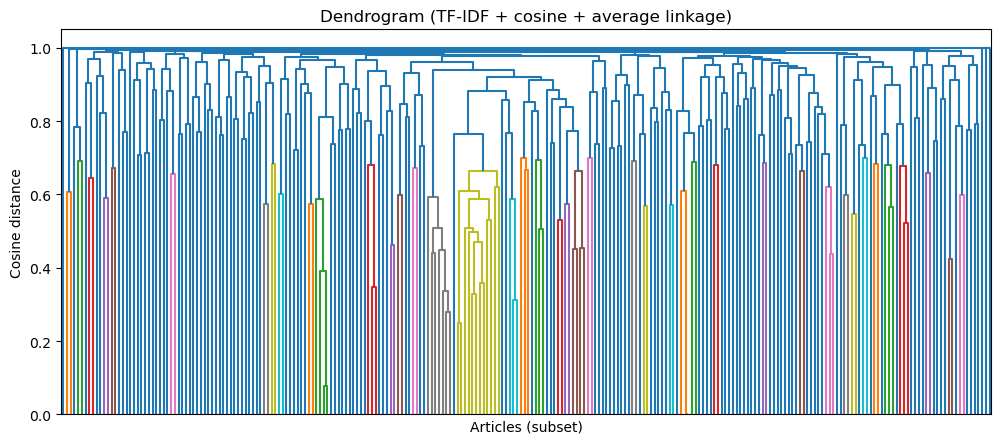

In [22]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# subset for dendrogram
rng = np.random.default_rng(42)
sub_n = min(250, X.shape[0])
sub_idx = rng.choice(X.shape[0], size=sub_n, replace=False)

X_sub = X[sub_idx].toarray()  # linkage needs dense

Z = sch.linkage(X_sub, method="average", metric="cosine")

plt.figure(figsize=(12, 5))
sch.dendrogram(Z, no_labels=True)
plt.title("Dendrogram (TF-IDF + cosine + average linkage)")
plt.xlabel("Articles (subset)")
plt.ylabel("Cosine distance")
plt.show()

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Choose k by silhouette on a manageable sample (Agglomerative is heavy on large n)
sil_n = min(1200, X.shape[0])
sil_idx = rng.choice(X.shape[0], size=sil_n, replace=False)
X_sil = X[sil_idx].toarray()


In [24]:
scores = {}
for k in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=k, metric="cosine", linkage="average")
    labels = hc.fit_predict(X_sil)
    scores[k] = silhouette_score(X_sil, labels, metric="cosine")

best_k = max(scores, key=scores.get)
print("Silhouette scores:", scores)
print("Best k:", best_k, "Best silhouette:", scores[best_k])

Silhouette scores: {2: 0.015197607998048736, 3: 0.01245337602800559, 4: 0.00921965107858386, 5: 0.00901855381306596, 6: 0.010222521859055691, 7: 0.01012273810333222, 8: 0.00990276049068827, 9: 0.010152848686025874, 10: 0.012364654132057456}
Best k: 2 Best silhouette: 0.015197607998048736


In [31]:
from sklearn.cluster import AgglomerativeClustering

k = 3  # try 3, 4, 5 for "few big themes"
hc = AgglomerativeClustering(n_clusters=k, metric="cosine", linkage="average")
y_hc = hc.fit_predict(X.toarray())  # Agglomerative needs dense in many setups


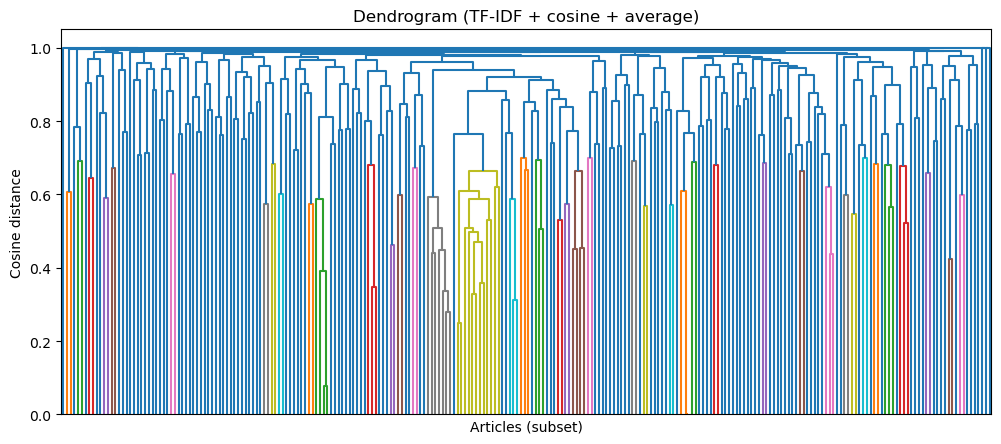

In [32]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np

sub_n = 250
rng = np.random.default_rng(42)
sub_idx = rng.choice(X.shape[0], size=min(sub_n, X.shape[0]), replace=False)

Z = sch.linkage(X[sub_idx].toarray(), method="average", metric="cosine")
plt.figure(figsize=(12,5))
sch.dendrogram(Z, no_labels=True)
plt.title("Dendrogram (TF-IDF + cosine + average)")
plt.xlabel("Articles (subset)")
plt.ylabel("Cosine distance")
plt.show()


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [34]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X) 

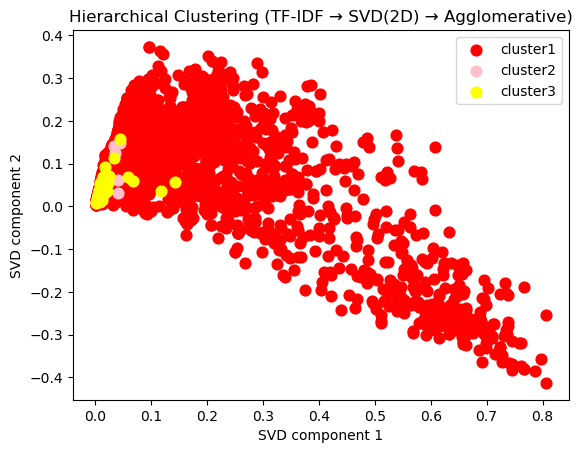

In [35]:
colors = ["red", "pink", "yellow", "violet", "blue", "green", "orange", "cyan"]
for c in range(k):
    plt.scatter(X_2d[y_hc == c, 0], X_2d[y_hc == c, 1],
                s=60, c=colors[c], label=f"cluster{c+1}")

plt.xlabel("SVD component 1")
plt.ylabel("SVD component 2")
plt.title("Hierarchical Clustering (TF-IDF → SVD(2D) → Agglomerative)")
plt.legend()
plt.show()